# ResNet50 Model | CIFAKE


In [1]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from keras.applications import ResNet50
from keras.optimizers import Adamax
from keras.regularizers import L1, L2
from keras.callbacks import EarlyStopping
from utils import (
    build_sequential_model,
    load_data,
    plot_performance_curves,
    save_model_history,
    load_model_history,
)
import PIL

PIL.Image.MAX_IMAGE_PIXELS = None

In [2]:
model_name = "resnet50-regularized-adamax-epochs100-noaug_seq-model_cifake"
dataset_base_path = "./datasets/CIFAKE"

# Forcefully train the model
force_model_train = False

# Don't save the model
no_save = False

In [3]:
# Load saved model and its history
model_history_loaded, classifier, history = load_model_history(model_name)

In [4]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3), pooling='max')
base_model.trainable = True

In [5]:
# Building model
if not model_history_loaded or force_model_train:
    classifier = build_sequential_model(
        layers=[
            Input(shape=(32, 32, 3)),
            base_model,
            BatchNormalization(),
            Dense(
                256,
                kernel_regularizer=L2(0.01),
                activity_regularizer=L1(0.01),
                bias_regularizer=L1(0.01),
                activation="relu",
            ),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(1, "sigmoid"),
        ],
        optimizer=Adamax(learning_rate=0.001),
    )

In [6]:
# Model summary
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                      

In [7]:
# Load augmented image generators
train_generator, validation_generator = load_data(
    dataset_base_path, augmented=False, batch_size=200
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [8]:
# Train model
if not model_history_loaded or force_model_train:
    history = classifier.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )
    history = history.history

In [9]:
# Save model
if not model_history_loaded or (force_model_train and not no_save) or not no_save:
    save_model_history(classifier, history, model_name)

INFO:tensorflow:Assets written to: ./models/resnet50-regularized-adamax-epochs100-noaug_seq-model_cifake/model\assets


INFO:tensorflow:Assets written to: ./models/resnet50-regularized-adamax-epochs100-noaug_seq-model_cifake/model\assets


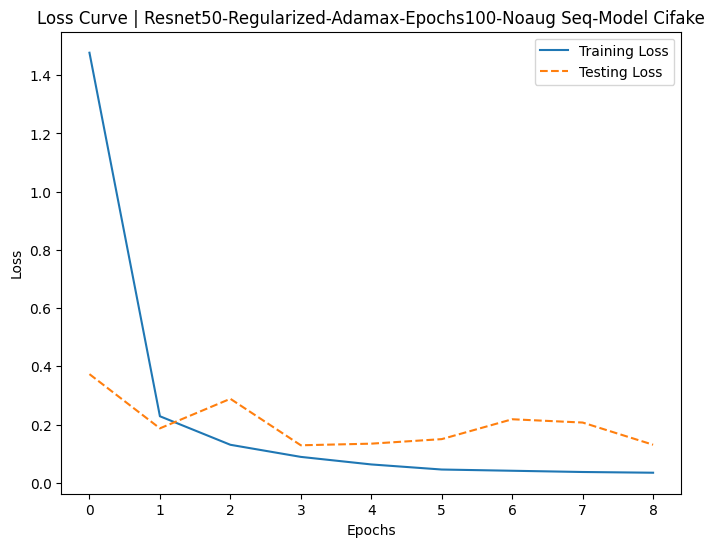

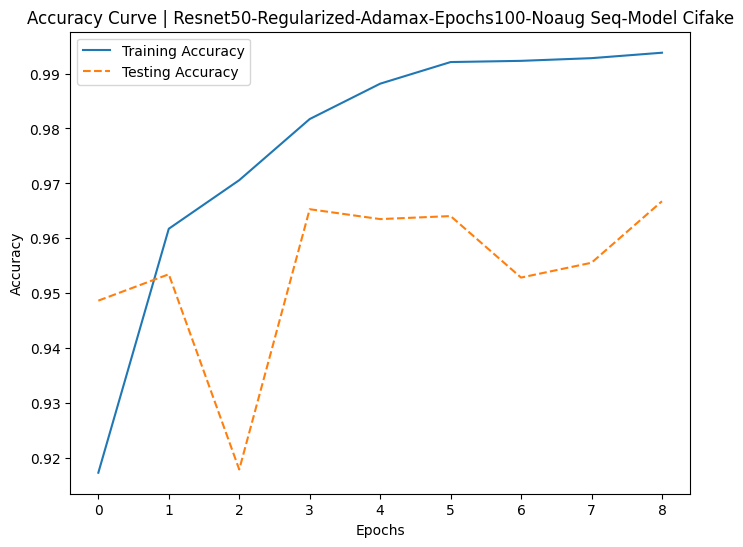

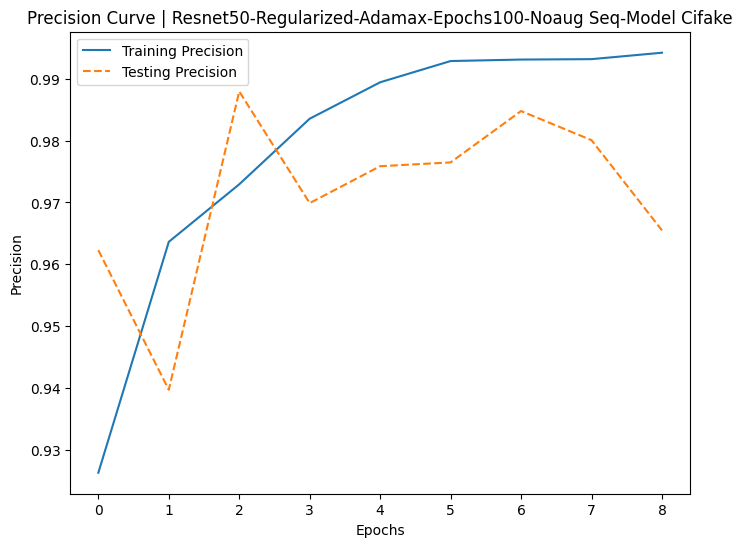

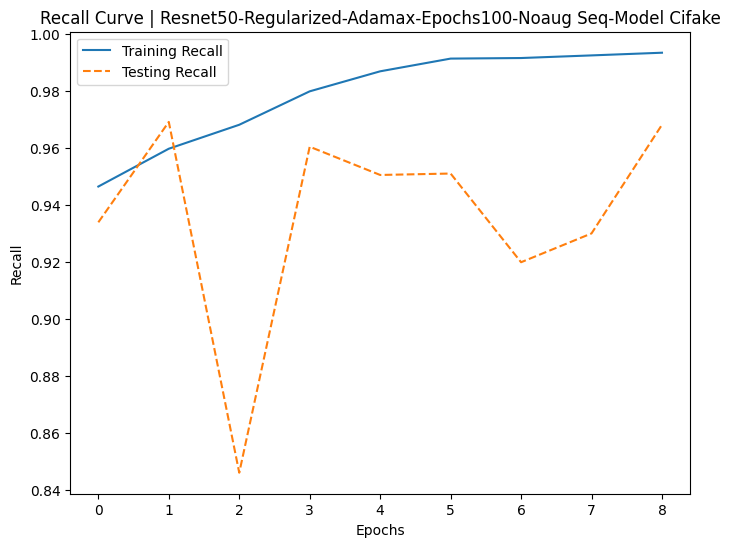

In [10]:
# Plot performance curves
plot_performance_curves(history, model_name)